In [62]:
import math

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from Utils import load_data, partition, seed, get_train_dataloader, get_test_dataloader, mean_absolute_percentage_error, \
    load_data_phase

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Change this flag if you want to use wandb
use_wandb = False

if use_wandb:
    import wandb

    with open('wandb_key') as key_file:
        wandb_key = key_file.readline()
    wandb.login(key=wandb_key)

seed()

In [63]:
def double_conv_block(in_channels: int, out_channels: int, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


def get_model(input_dim, output_dim):
    conv_part = nn.Sequential(
        double_conv_block(input_dim[0], 16, 3),
        double_conv_block(16, 32, 3),
        double_conv_block(32, 64, 3),
        nn.Flatten())

    x = torch.unsqueeze(torch.zeros(input_dim), 0)
    size = conv_part.forward(x).size()[1]
    print('Flatten size:', size)

    model = nn.Sequential(
        conv_part,
        nn.Linear(size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    model.to(device)
    return model

In [64]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()

            if phase == 'train':
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

            if phase == 'val' and best_val_loss > epoch_loss:
                print('new best val loss', epoch_loss, 'epoch', epoch)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

        if use_wandb and phase == 'val':
            wandb.log({f'train loss': train_loss, f'val loss': val_loss})

    return model

In [65]:
def load_model(file, input_dim, output_dim):
    model = get_model(input_dim, output_dim)
    model.load_state_dict(torch.load(file)['model_state_dict'])
    model.eval()
    return model

In [66]:
lr = 1e-3
epochs = 200
batch_size = 4
step_size = 20
gamma = 0.5

output_dim = 1

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "optim": 'Adam',
    "pref": 'forward',
}
important_keys = ['optim', 'bs', 'pref']
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

In [67]:
def test(x_train, y_train, x_val, y_val):
    n = 4

    x_train_list, y_train_list = partition(x_train, y_train, n)

    for i in range(n):
        seed()
        x_train_list_new = list(x_train_list)
        x_train_list_new.pop(i)
        y_train_list_new = list(y_train_list)
        y_train_list_new.pop(i)

        x_train, y_train = np.concatenate(x_train_list_new), np.concatenate(y_train_list_new)
        x_test, y_test = x_train_list[i], y_train_list[i]

        x_train, y_train = torch.FloatTensor(x_train).to(device), torch.FloatTensor(y_train).to(device)
        x_test, y_test = torch.FloatTensor(x_test).to(device), torch.FloatTensor(y_test).to(device)

        train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
        test_dataloader = get_test_dataloader(x_test, y_test, batch_size)

        model = get_model(x_train[0].size(), output_dim)

        loss_func = torch.nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

        best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), output_dim)

        y_test_result = best_model.forward(x_test).detach()
        y_train_result = best_model.forward(x_train).detach()
        y_val_result = best_model.forward(x_val).detach()

        yield y_train, y_train_result, y_test, y_test_result, y_val, y_val_result

In [68]:
params = ['D']

x_train, y_train = load_data_phase('Data_V_D', params, (64, 64))
mean = y_train.mean(axis=0)
dispersion = ((y_train - mean) ** 2).mean(axis=0)
y_train = (y_train - mean) / np.sqrt(dispersion)

def norm(array):
    return (array - mean) / np.sqrt(dispersion)
def denorm(array):
    return array * np.sqrt(dispersion) + mean

x_val, y_val = load_data_phase('Test', params, (64, 64))
y_val = norm(y_val)
x_val, y_val = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), (x_val, y_val))

print('data count', len(x_train))

result_V = list(test(x_train, y_train, x_val, y_val))

125
4
data count 125
[[0, 6, 7, 12, 17, 18, 20, 25, 27, 28, 40, 42, 43, 50, 55, 58, 59, 63, 65, 83, 85, 92, 94, 95, 96, 97, 101, 112, 119, 122, 123, 124], [4, 13, 15, 16, 19, 22, 26, 30, 34, 35, 36, 38, 46, 49, 53, 60, 61, 67, 70, 80, 82, 87, 91, 98, 102, 107, 109, 110, 111, 113, 117], [1, 2, 3, 9, 21, 24, 31, 32, 33, 45, 51, 52, 57, 68, 71, 73, 75, 76, 81, 84, 90, 93, 99, 100, 103, 105, 108, 114, 115, 116, 118], [5, 8, 10, 11, 14, 23, 29, 37, 39, 41, 44, 47, 48, 54, 56, 62, 64, 66, 69, 72, 74, 77, 78, 79, 86, 88, 89, 104, 106, 120, 121]]
Flatten size: 1024
351361
new best val loss 0.5228160414844751 epoch 0
new best val loss 0.46101186983287334 epoch 1
new best val loss 0.38127535209059715 epoch 3
new best val loss 0.32216606102883816 epoch 8
new best val loss 0.19741204846650362 epoch 9
new best val loss 0.17507594171911478 epoch 10
new best val loss 0.14720339560881257 epoch 11
new best val loss 0.08613955741748214 epoch 16
new best val loss 0.07923008082434535 epoch 17
new best val

V
train_error 0.010635 test_error 0.041457 val_error 0.12005

train_error 0.041407 test_error 0.028855 val_error 0.287007

train_error 0.023354 test_error 0.047457 val_error 0.058745

train_error 0.017233 test_error 0.025443 val_error 0.04057



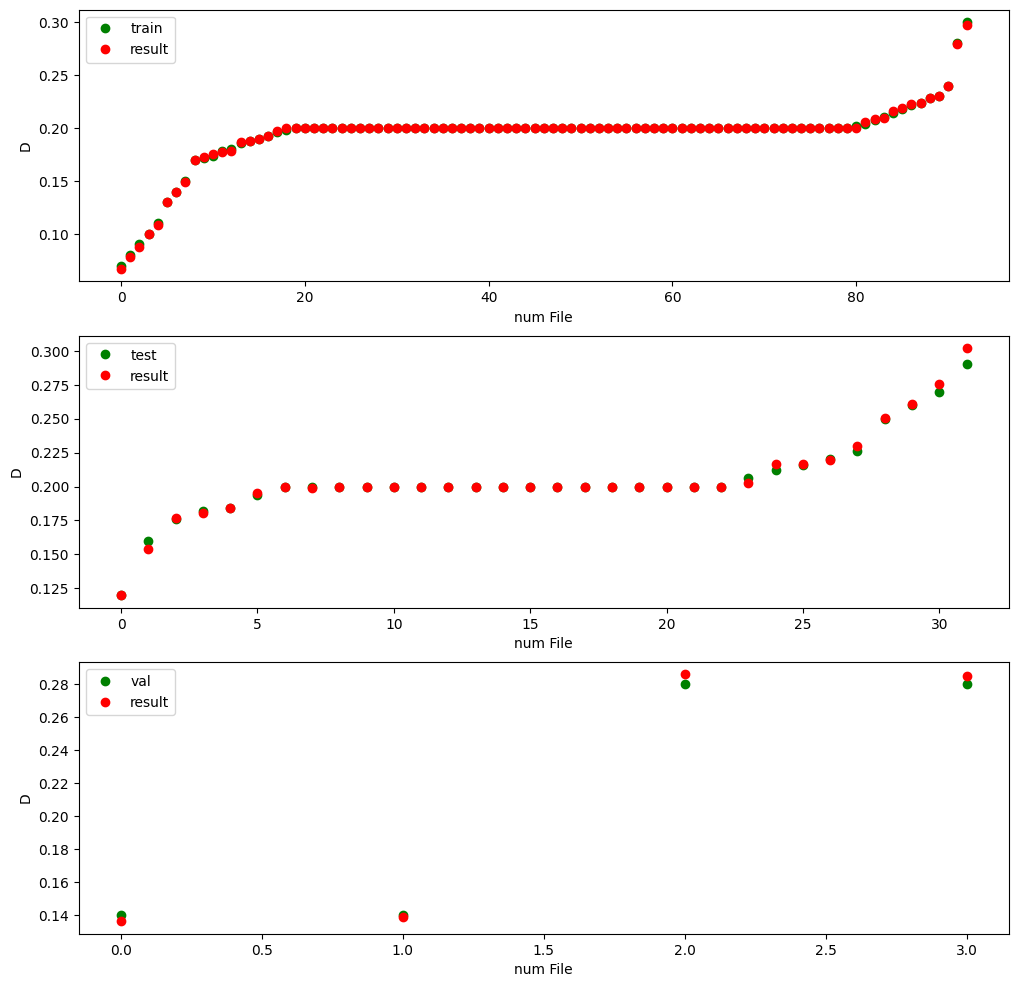

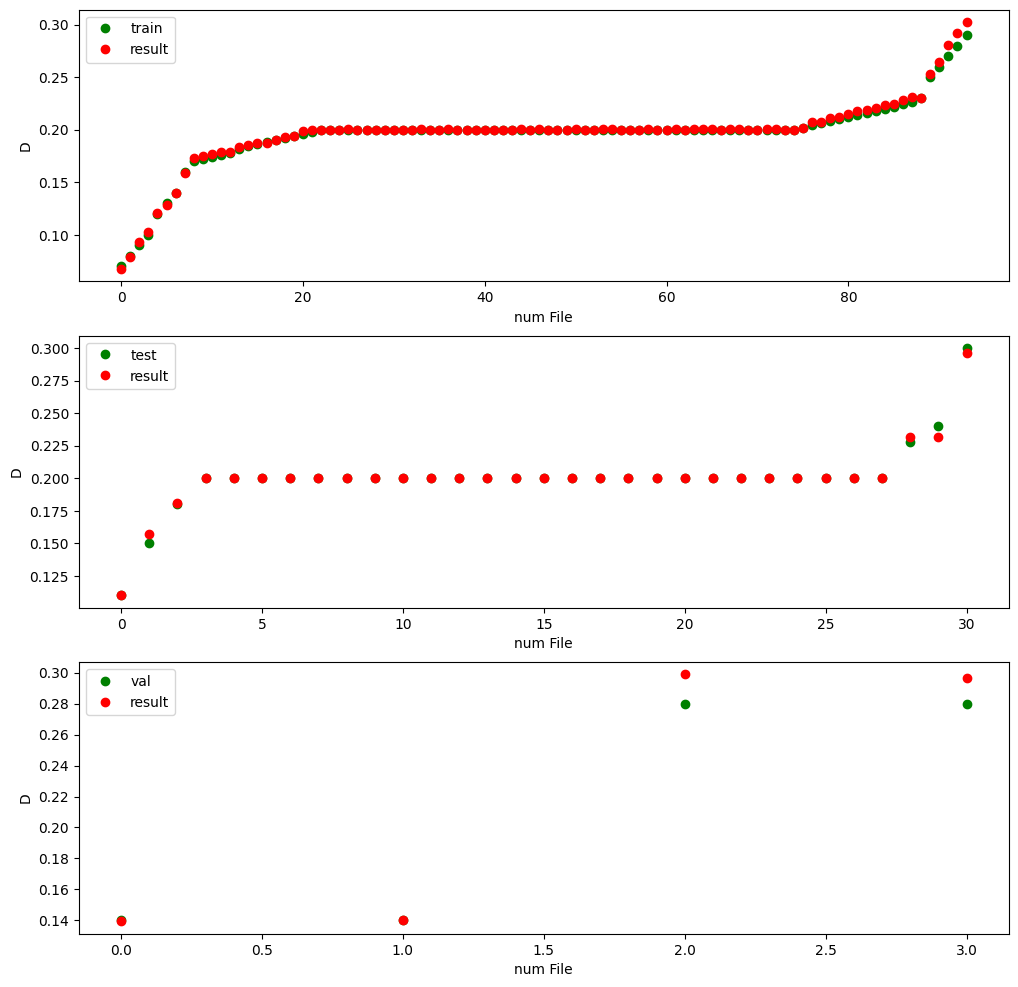

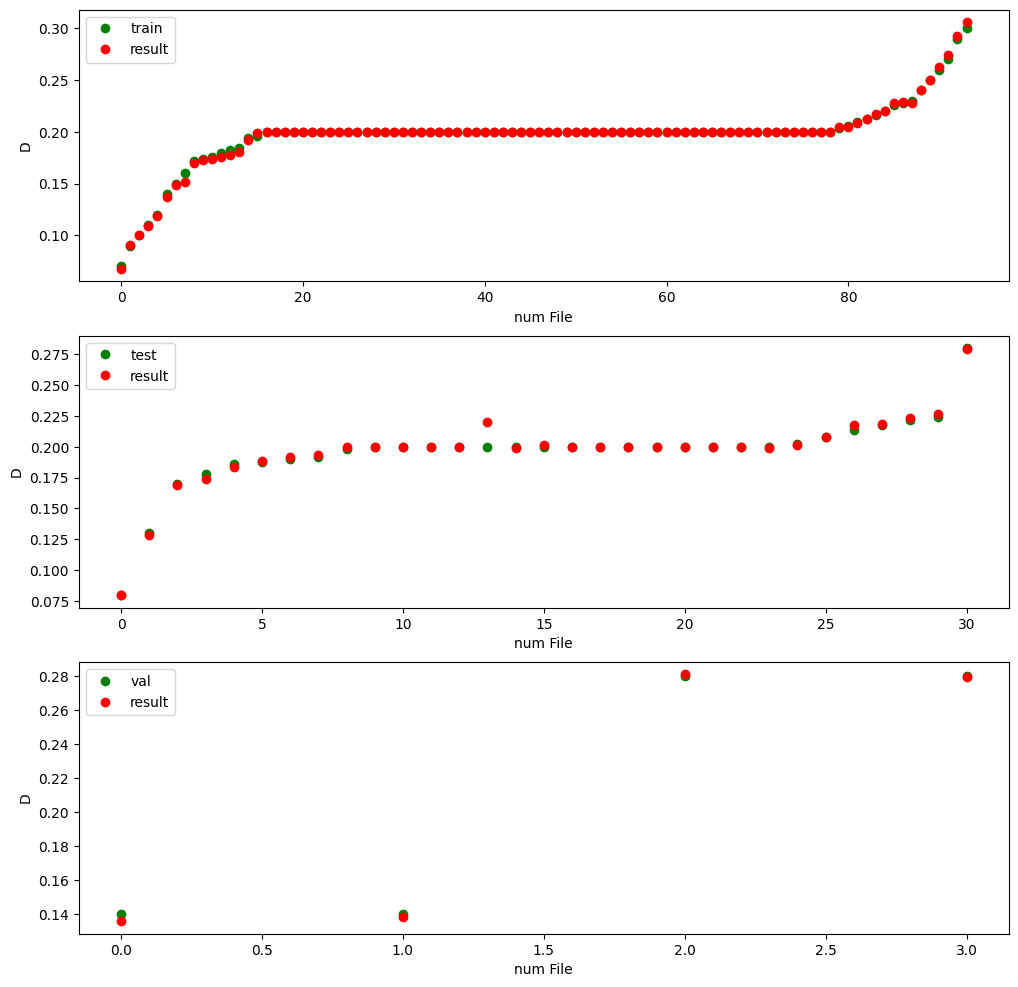

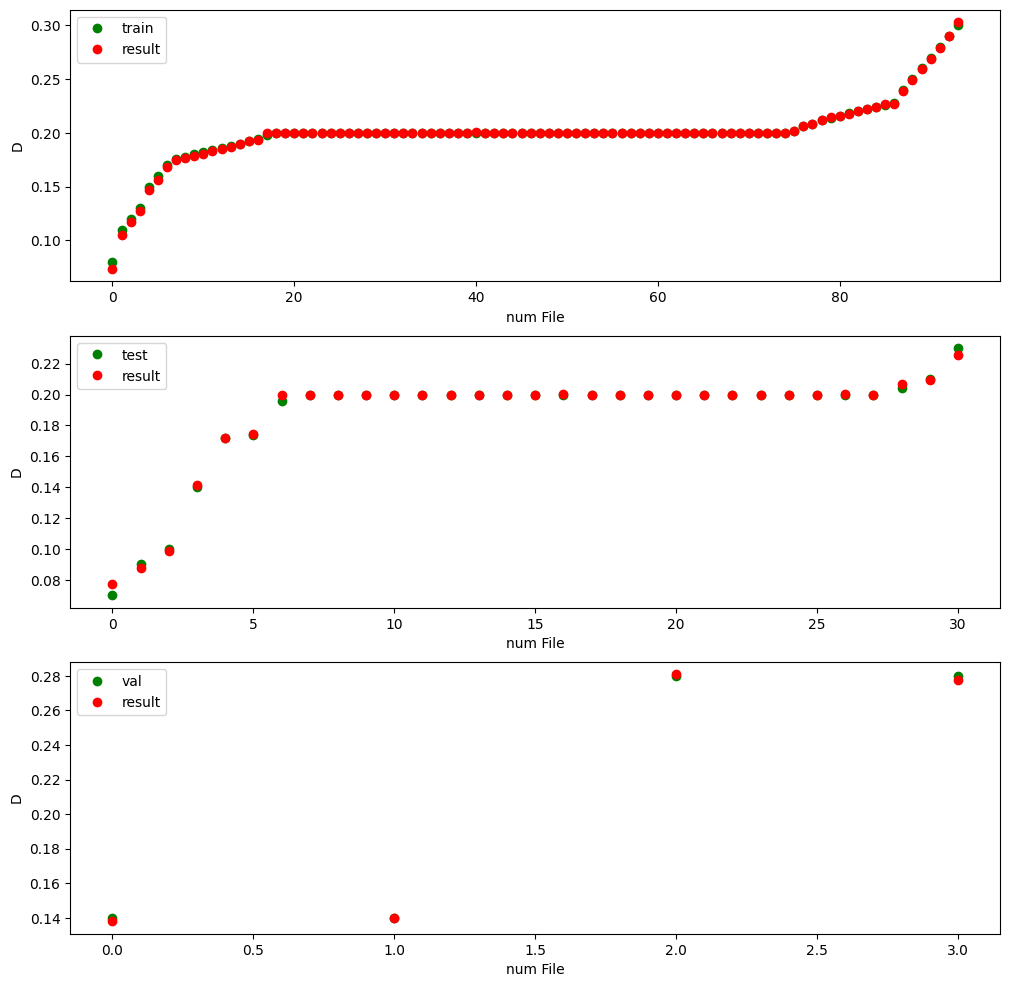

In [69]:
def show(title, results):
    print(title)
    for y_train, y_train_result, y_test, y_test_result, y_val, y_val_result in results:
        train_error = torch.nn.L1Loss()(y_train_result, y_train).item()
        test_error = torch.nn.L1Loss()(y_test_result, y_test).item()
        val_error = torch.nn.L1Loss()(y_val_result, y_val).item()
        print('train_error', round(train_error, 6), 'test_error', round(test_error, 6), 'val_error', round(val_error, 6))
        print()

        y_test_result_np = y_test_result.detach().cpu().numpy()
        y_train_result_np = y_train_result.detach().cpu().numpy()
        y_val_result_np = y_val_result.detach().cpu().numpy()
        y_test_np = y_test.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        y_val_np = y_val.cpu().numpy()

        i = 0

        sort = y_train_np[:, i].argsort(axis=0).reshape((-1,))

        fig = plt.figure(figsize=(12, 12))
        ax_train = fig.add_subplot(3, 1, 1)
        ax_train.plot(denorm(y_train_np[sort][:, i]), 'go', label='train')
        ax_train.plot(denorm(y_train_result_np[sort][:, i]), 'ro', label='result')
        ax_train.set_ylabel(params[i])
        ax_train.set_xlabel('num File')
        ax_train.legend()

        sort = y_test_np[:, i].argsort(axis=0).reshape((-1,))

        ax_test = fig.add_subplot(3, 1, 2)
        ax_test.plot(denorm(y_test_np[sort][:, i]), 'go', label='test')
        ax_test.plot(denorm(y_test_result_np[sort][:, i]), 'ro', label='result')
        ax_test.set_ylabel(params[i])
        ax_test.set_xlabel('num File')
        ax_test.legend()

        sort = y_val_np[:, i].argsort(axis=0).reshape((-1,))

        ax_test = fig.add_subplot(3, 1, 3)
        ax_test.plot(denorm(y_val_np[sort][:, i]), 'go', label='val')
        ax_test.plot(denorm(y_val_result_np[sort][:, i]), 'ro', label='result')
        ax_test.set_ylabel(params[i])
        ax_test.set_xlabel('num File')
        ax_test.legend()

    plt.show()

show('V', result_V)